# **A crude Tensorflow 2.x (using Keras functional API) implementation of  [Supervised Autoencoders ](https://proceedings.neurips.cc/paper/2018/file/2a38a4a9316c49e5a833517c45d31070-Paper.pdf).**


Le, Lei, Andrew Patterson, and Martha White. "Supervised Autoencoders: Improving Generalization Performance with Unsupervised Regularizers." Advances in Neural Information Processing Systems 31 (2018).

In [1]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Concatenate, Flatten, Input, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanSquaredError as metricMSE, SparseCategoricalAccuracy
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import pandas as pd

The model has two outputs (and therefore two losses): a supervised classification output and an unsupervised reconstruction output. The classifier bit takes its input from the encoder. 

In [3]:

def get_model(inpuy_shape= (28, 28, 1), latent_dimensions = 20, num_classes = 10, init_type = 'GlorotNormal'):

    # encoder
    encoder_input = Input(shape=(28, 28, 1))
    encoder = Flatten()(encoder_input)
    encoder = Dense(784, activation='relu', kernel_initializer=init_type)(encoder)
    encoder = Dense(300, activation = 'relu', kernel_initializer=init_type)(encoder)
    encoder = Dense(100, activation = 'relu', kernel_initializer=init_type)(encoder)
    encoder_output = Dense(latent_dimensions, activation='relu', kernel_initializer=init_type, name="encoder_output")(encoder)
    
    # "supervised learner"
    classifier = Dense(num_classes, activation='sigmoid', kernel_initializer=init_type, name = "classifier")(encoder_output) # first of the two outputs

    # decoder
    decoder = Dense(100, activation='relu', kernel_initializer=init_type)(encoder_output)
    decoder = Dense(300, activation='relu', kernel_initializer=init_type)(decoder)
    decoder = Dense(784, activation='linear', kernel_initializer=init_type)(decoder)
    decoder_output = Reshape((28, 28, 1), name = "reconstructer")(decoder) # second of the two outputs


    model = Model(inputs = encoder_input, outputs = [classifier, decoder_output])

    return model



The two lossses are summed (note the 1:1 weights below) to yield the combined classification + reconstruction loss, and backpropagation is carried w.r.t that sum.

In [4]:
model = get_model((28, 28, 1), 20, 10)
model.compile(optimizer=Adam(0.001), 
              loss = {"classifier" : SparseCategoricalCrossentropy(), "reconstructer":MeanSquaredError()}, 
              metrics = {"classifier" : SparseCategoricalAccuracy(), "reconstructer":metricMSE()},
              loss_weights = {"classifier":1.0, "reconstructer":1.0})

Plot the model (w/ input shapes and dtypes).

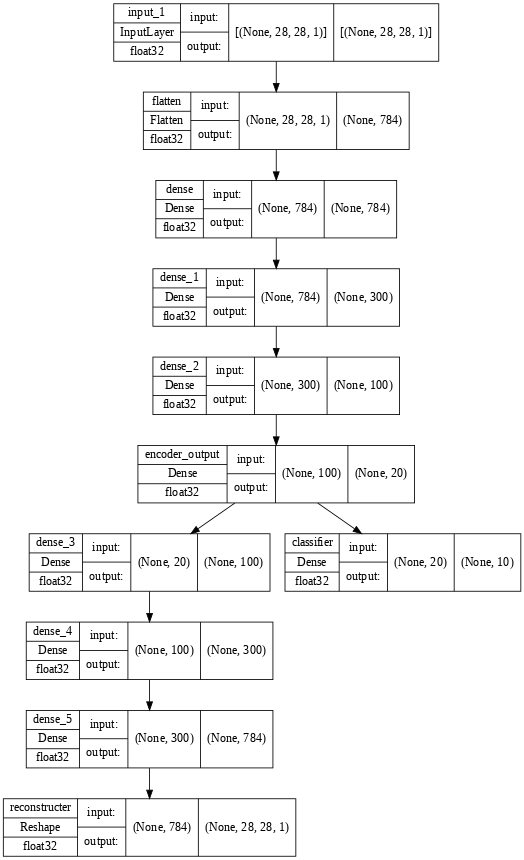

In [5]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    dpi = 60)
#model.summary()

Load MNIST data and print shapes. 

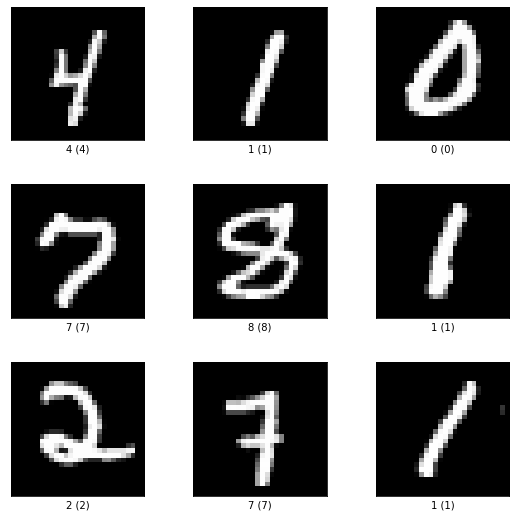

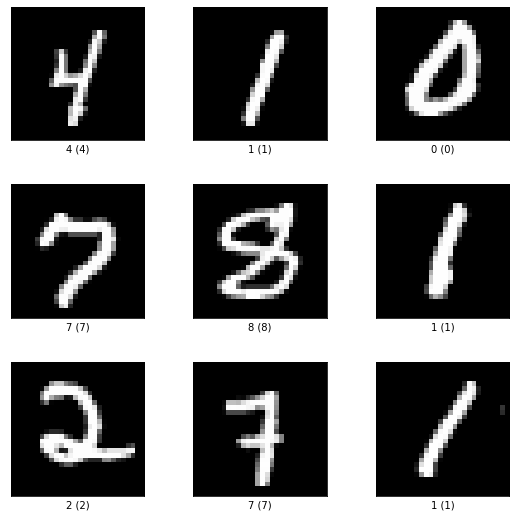

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

tfds.show_examples(ds_train, ds_info)



In [7]:
ds_train = ds_train.batch(32)
ds_test = ds_test.batch(32)

for (x, y) in ds_train.take(1):
    print(f"x is of shape:{x.shape}\ny is of shape:{y.shape}")

x is of shape:(32, 28, 28, 1)
y is of shape:(32,)


In [8]:
model.fit(ds_train, validation_data=ds_test, 
          epochs=50, 
          callbacks=[CSVLogger('logs.csv'), 
                     ReduceLROnPlateau( monitor = 'val_loss', mode = 'min', 
                                       factor=0.5, patience=2, min_lr = 1e-6)],
          )

Epoch 1/50
1875/1875 [==============================] - 24s 11ms/step - loss: 10.6094 - classifier_loss: 1.4475 - reconstructer_loss: 9.1619 - classifier_sparse_categorical_accuracy: 0.5911 - reconstructer_mean_squared_error: 9.1619 - val_loss: 8.9406 - val_classifier_loss: 0.2656 - val_reconstructer_loss: 8.6749 - val_classifier_sparse_categorical_accuracy: 0.9315 - val_reconstructer_mean_squared_error: 8.6749 - lr: 0.0010
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 8.8415 - classifier_loss: 0.2117 - reconstructer_loss: 8.6298 - classifier_sparse_categorical_accuracy: 0.9441 - reconstructer_mean_squared_error: 8.6298 - val_loss: 8.7929 - val_classifier_loss: 0.2242 - val_reconstructer_loss: 8.5687 - val_classifier_sparse_categorical_accuracy: 0.9409 - val_reconstructer_mean_squared_error: 8.5687 - lr: 0.0010
Epoch 3/50
1875/1875 [==============================] - 10s 5ms/step - loss: 8.6722 - classifier_loss: 0.1436 - reconstructer_loss: 8.5286 - classi

Visualizing the logs

In [9]:
!head -n 5 logs.csv

epoch,classifier_loss,classifier_sparse_categorical_accuracy,loss,reconstructer_loss,reconstructer_mean_squared_error,val_classifier_loss,val_classifier_sparse_categorical_accuracy,val_loss,val_reconstructer_loss,val_reconstructer_mean_squared_error
0,1.4474759101867676,0.5911499857902527,10.609396934509277,9.161918640136719,9.161931037902832,0.2656172215938568,0.9315000176429749,8.940559387207031,8.674946784973145,8.674945831298828
1,0.21168836951255798,0.9440500140190125,8.841536521911621,8.629840850830078,8.629834175109863,0.22420194745063782,0.9409000277519226,8.79289722442627,8.568696022033691,8.568699836730957
2,0.14356030523777008,0.9628000259399414,8.672202110290527,8.528630256652832,8.528634071350098,0.1897854059934616,0.9539999961853027,8.604705810546875,8.414920806884766,8.414920806884766
3,0.12937499582767487,0.9673166871070862,8.518668174743652,8.389291763305664,8.389290809631348,0.16837935149669647,0.9599000215530396,8.57181167602539,8.403429985046387,8.40343189239502


In [10]:
dflogs = pd.read_csv('logs.csv', header=0)
dflogs.head()

,epoch,classifier_loss,classifier_sparse_categorical_accuracy,loss,reconstructer_loss,reconstructer_mean_squared_error,val_classifier_loss,val_classifier_sparse_categorical_accuracy,val_loss,val_reconstructer_loss,val_reconstructer_mean_squared_error
0,0,1.447476,0.591150,10.609397,9.161919,9.161931,0.265617,0.9315,8.940559,8.674947,8.674946
1,1,0.211688,0.944050,8.841537,8.629841,8.629834,0.224202,0.9409,8.792897,8.568696,8.568700
2,2,0.143560,0.962800,8.672202,8.528630,8.528634,0.189785,0.9540,8.604706,8.414921,8.414921
3,3,0.129375,0.967317,8.518668,8.389292,8.389291,0.168379,0.9599,8.571812,8.403430,8.403432
4,4,0.108583,0.971417,8.471267,8.362686,8.362688,0.144339,0.9674,8.545799,8.401460,8.401461


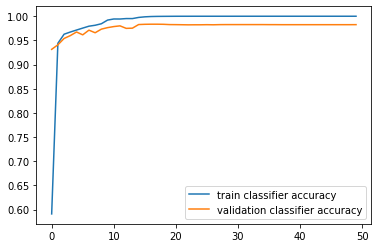

In [11]:
plt.figure()
plt.plot(dflogs.epoch, dflogs.classifier_sparse_categorical_accuracy, label= 'train classifier accuracy')
plt.plot(dflogs.epoch, dflogs.val_classifier_sparse_categorical_accuracy, label= 'validation classifier accuracy')
plt.legend(loc='best')
plt.show()

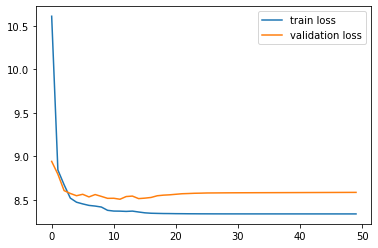

In [12]:
plt.figure()
plt.plot(dflogs.epoch, dflogs.loss, label= 'train loss')
plt.plot(dflogs.epoch, dflogs.val_loss, label= 'validation loss')
plt.legend(loc='best')
plt.show()

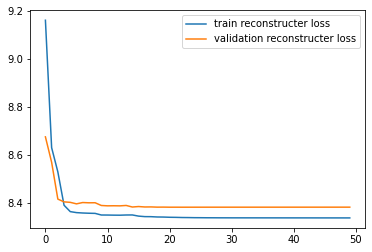

In [13]:
plt.figure()
plt.plot(dflogs.epoch, dflogs.reconstructer_loss, label= 'train reconstructer loss')
plt.plot(dflogs.epoch, dflogs.val_reconstructer_loss, label= 'validation reconstructer loss')
plt.legend(loc='best')
plt.show()

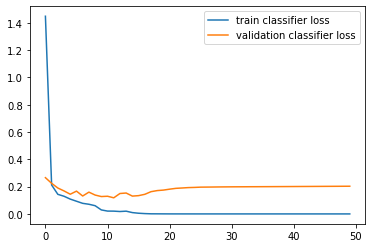

In [14]:
plt.figure()
plt.plot(dflogs.epoch, dflogs.classifier_loss, label= 'train classifier loss')
plt.plot(dflogs.epoch, dflogs.val_classifier_loss, label= 'validation classifier loss')
plt.legend(loc='best')
plt.show()

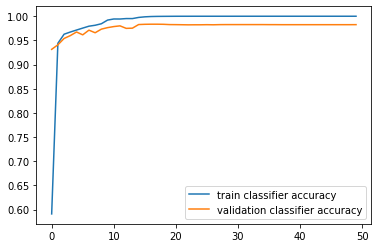

In [15]:
plt.figure()
plt.plot(dflogs.epoch, dflogs.classifier_sparse_categorical_accuracy, label= 'train classifier accuracy')
plt.plot(dflogs.epoch, dflogs.val_classifier_sparse_categorical_accuracy, label= 'validation classifier accuracy')
plt.legend(loc='best')
plt.show()